In [1]:
# importation des librairies
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
from torch import nn
from river import base
from river import metrics
from river import stream
# from codecarbon import OfflineEmissionsTracker
from os import path
import json
from math import *

# Choix de la cpu, gpu ou autre
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Build neural network model

In [33]:
# Définition de l'architecture du modèle
class Architecture(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),  # Class multi-label
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


# Définition et initialisation du modèle pour river, avec les fonctions learn_one et predict_one sur une seule instance du flux 
class NN(base.MultiLabelClassifier):
    def __init__(
        self,
        learning_rate=0.001,
        feature_size=1006, #Taille des vecteurs en entrée
        hidden_sizes=300,
        label_size=20, #Label a prédire
    ):

        # SETTING UP THE MODEL
        self.model = Architecture(
            feature_size,hidden_sizes, label_size
        ).to(device)
        self.model = self.model.double() #Convertie le type de donnée en double
        self.loss = nn.BCELoss() #Fc de perte
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )


    #x -> Dico de caractéristique pour une instance de données
    #y -> Dico de label pour l'instance
    def learn_one(self, x: dict, y: dict):
        feature_tensor = torch.from_numpy(x).double().to(device)
        label_tensor = torch.from_numpy(y).double().to(device)

        # forward + backward + optimize
        pred_tensor = self.model.forward(feature_tensor)
        lossVal = self.loss(pred_tensor, label_tensor)
        lossVal.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def predict_one(self, features: dict): #Renvoit un prédiction pour chaque label comprise entre 0 et 1.
        feature_tensor = torch.from_numpy(features).double().to(device)
        pred_tensor = self.model.forward(feature_tensor)
        pred_detached = pred_tensor.cpu().clone().detach()
        pred = pred_detached.numpy() #Convertit en numpy
        return pred.copy()

# Apprentissage sur le flux

In [13]:
# Choix du jeu de données, définition des targets dans le modèle, choix de la métrique, définition du modèle
dataset = "data/datasets/20NG.arff"
target = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]
metric = metrics.multioutput.SampleAverage(metrics.Jaccard()) #Métrique pour la perf du modèle
metric_over_time = []
i = 0
model = NN(learning_rate=0.001,hidden_sizes=300)

# Définition du tracker pour code carbon, qui permet de suivre et d'estimer les émissions de CO2 liées à l'éxec du code
# tracker = OfflineEmissionsTracker(
#         tracking_mode="process",
#         output_file="output/consommation.csv",
#         country_iso_code="FRA")
# tracker.start()

#Début de l'évaluation sur le flux
for x, y in stream.iter_arff(dataset, target, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
    # Répartition des attributs sur un array numpy
    new_x = np.zeros(1006)
    for key, value in x.items():
        x[key] = float(value) #Convertie la valeur de l'attribut en flottant
        k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
        new_x[k] = value
    # Prédiction
    y_pred = model.predict_one(new_x)
    n = 0
    # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
    dict_y_pred = dict()
    for j in y_pred :
        if j == None : j = False
        elif j >= 0.5 : j = True
        else : j = False
        dict_y_pred['y{}'.format(n)] = j
        n+=1
    # Assurance que le dictionnaire y ne contienne que des trues et false
    for k, v in y.items():
        y[k] = v == "1" #Convertit chaque label en booléen
    # Répartition des labels de y sur un array numpy
    new_y = np.zeros(20)
    for key, value in y.items():
        k = int(re.findall(r'\d+',key)[0])
        new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
    # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
    metric.update(y, dict_y_pred)
    print("{} | ".format(i) + "Jaccard accuracy : {}".format(metric.get()))
    metric_over_time.append(metric.get())
    i+=1
    # Apprentissage sur les array numpy de x et y
    model.learn_one(new_x, new_y)
# Fin du tracker de code carbone
# tracker.stop()

# Enregistrement des résultats sur un fichier json
with open("output/results.json", "w") as outfile:
    json.dump(metric_over_time, outfile)


0 | Jaccard accuracy : 0.0
1 | Jaccard accuracy : 0.05
2 | Jaccard accuracy : 0.06111111111111111
3 | Jaccard accuracy : 0.09583333333333333
4 | Jaccard accuracy : 0.07666666666666666
5 | Jaccard accuracy : 0.11944444444444444
6 | Jaccard accuracy : 0.10238095238095238
7 | Jaccard accuracy : 0.08958333333333333
8 | Jaccard accuracy : 0.07962962962962963
9 | Jaccard accuracy : 0.07166666666666667
10 | Jaccard accuracy : 0.06515151515151515
11 | Jaccard accuracy : 0.059722222222222225
12 | Jaccard accuracy : 0.055128205128205134
13 | Jaccard accuracy : 0.051190476190476196
14 | Jaccard accuracy : 0.04777777777777778
15 | Jaccard accuracy : 0.04479166666666667
16 | Jaccard accuracy : 0.04215686274509804
17 | Jaccard accuracy : 0.03981481481481482
18 | Jaccard accuracy : 0.037719298245614034
19 | Jaccard accuracy : 0.035833333333333335
20 | Jaccard accuracy : 0.03412698412698413
21 | Jaccard accuracy : 0.03257575757575758
22 | Jaccard accuracy : 0.031159420289855074
23 | Jaccard accuracy :

KeyboardInterrupt: 

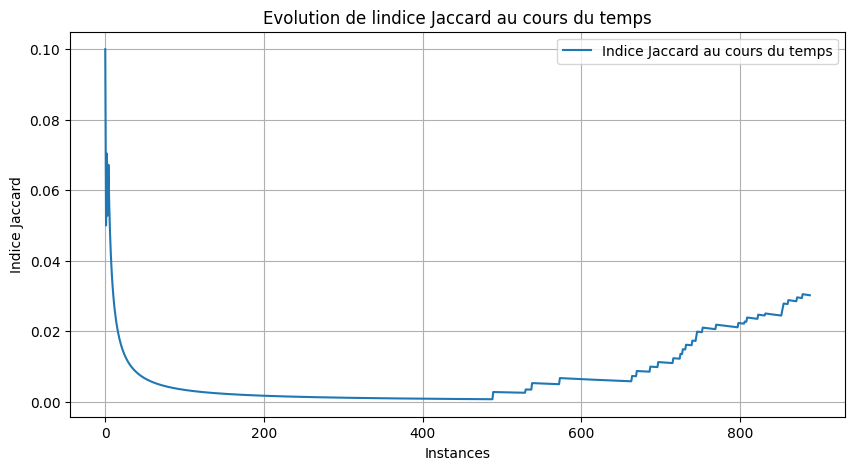

In [8]:


# Création du graphique
plt.figure(figsize=(10, 5))
plt.plot(metric_over_time, label='Indice Jaccard au cours du temps')
plt.xlabel('Instances')
plt.ylabel('Indice Jaccard')
plt.title('Evolution de l''indice Jaccard au cours du temps')
plt.legend()
plt.grid(True)
# plt.ylim(0, 1)
plt.show()


In [14]:
def NN_iteration(dataset_path, target_labels, epochs=1):
    results = []

    for epoch in range(epochs):
        # Initialiser le modèle avec la taille de couche cachée actuelle
        model = NN(learning_rate=0.001,feature_size=1006,hidden_sizes=300, label_size=20)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())

        # Boucle sur le dataset
        for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
            # Répartition des attributs sur un array numpy
            new_x = np.zeros(1006)
            for key, value in x.items():
                x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                new_x[k] = value
            # Prédiction
            y_pred = model.predict_one(new_x)
            n = 0
            # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
            dict_y_pred = dict()
            for j in y_pred :
                if j == None : j = False
                elif j >= 0.5 : j = True
                else : j = False
                dict_y_pred['y{}'.format(n)] = j
                n+=1
            # Assurance que le dictionnaire y ne contienne que des trues et false
            for k, v in y.items():
                y[k] = v == "1" #Convertit chaque label en booléen
            # Répartition des labels de y sur un array numpy
            new_y = np.zeros(20)
            for key, value in y.items():
                k = int(re.findall(r'\d+',key)[0])
                new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                
            # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
            metric.update(y, dict_y_pred)
            metric_over_time.append(metric.get())
            # Apprentissage sur les array numpy de x et y
            model.learn_one(new_x, new_y)

        results.append(metric.get())
        print("Epoch",epoch,"Indice Jaccard",results[epoch])

    return results


dataset_path = "data/datasets/20NG.arff"

target_labels = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]

results = NN_iteration(dataset_path, target_labels,5)

Epoch 0 Indice Jaccard 0.5718354529753488
Epoch 1 Indice Jaccard 0.5706879677605093
Epoch 2 Indice Jaccard 0.5702662636730018
Epoch 3 Indice Jaccard 0.5715562359344741
Epoch 4 Indice Jaccard 0.5714581791265714


In [16]:
moy = np.mean(results)
print(moy)
sd = np.std(results)
print(sd)


0.571160819893981
0.000587150087351272


## Optimisation des méta-paramètres

### Méta-paramètre : Nombre de couche

In [34]:
import time
def optimize_neuron_count(hidden_sizes, dataset_path, target_labels, epochs=1):
    results = {}
    time_results = {}

    for hidden_size in hidden_sizes:
        print(f"Testing hidden layer size: {hidden_size}")
        # Initialiser le modèle avec la taille de couche cachée actuelle
        model = NN(learning_rate=0.01,feature_size=1006,hidden_sizes=hidden_size, label_size=20)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())

        # Boucle sur le dataset
        for epoch in range(epochs):
            start_time = time.time()  # Début de mesure du temps pour l'epoch
            for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
                # Répartition des attributs sur un array numpy
                new_x = np.zeros(1006)
                for key, value in x.items():
                    x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                    k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                    new_x[k] = value
                # Prédiction
                y_pred = model.predict_one(new_x)
                n = 0
                # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
                dict_y_pred = dict()
                for j in y_pred :
                    if j == None : j = False
                    elif j >= 0.5 : j = True
                    else : j = False
                    dict_y_pred['y{}'.format(n)] = j
                    n+=1
                # Assurance que le dictionnaire y ne contienne que des trues et false
                for k, v in y.items():
                    y[k] = v == "1" #Convertit chaque label en booléen
                # Répartition des labels de y sur un array numpy
                new_y = np.zeros(20)
                for key, value in y.items():
                    k = int(re.findall(r'\d+',key)[0])
                    new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                    
                # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
                metric.update(y, dict_y_pred)
                metric_over_time.append(metric.get())
                # Apprentissage sur les array numpy de x et y
                model.learn_one(new_x, new_y)

            end_time = time.time()  # Fin de mesure du temps pour l'epoch
            epoch_duration = end_time - start_time
            print(f"Epoch {epoch+1}, Time: {epoch_duration}")
            metric_over_time.append(metric.get())
            print(f"Epoch {epoch+1}, Jaccard accuracy: {metric.get()}")

        results[hidden_size] = metric.get()
        time_results[hidden_size] = epoch_duration
        print(f"Hidden Size {hidden_size}, Jaccard Index: {results[hidden_size]}, Time : {time_results[hidden_size]}")

    return results,time_results

# Liste des tailles de couches cachées à tester
hidden_sizes = [100, 300, 600,900]

dataset_path = "data/datasets/20NG.arff"

target_labels = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]

neuron_results,time_results = optimize_neuron_count(hidden_sizes, dataset_path, target_labels)

Testing hidden layer size: 100
Epoch 1, Time: 46.50607705116272
Epoch 1, Jaccard accuracy: 0.4559300518134728
Hidden Size 100, Jaccard Index: 0.4559300518134728, Time : 46.50607705116272
Testing hidden layer size: 300
Epoch 1, Time: 78.26134848594666
Epoch 1, Jaccard accuracy: 0.4697469775474959
Hidden Size 300, Jaccard Index: 0.4697469775474959, Time : 78.26134848594666
Testing hidden layer size: 600
Epoch 1, Time: 140.5538227558136
Epoch 1, Jaccard accuracy: 0.4646830742659739
Hidden Size 600, Jaccard Index: 0.4646830742659739, Time : 140.5538227558136
Testing hidden layer size: 900
Epoch 1, Time: 281.7207341194153
Epoch 1, Jaccard accuracy: 0.47603540587219295
Hidden Size 900, Jaccard Index: 0.47603540587219295, Time : 281.7207341194153


[46.50607705116272, 78.26134848594666, 140.5538227558136, 281.7207341194153]


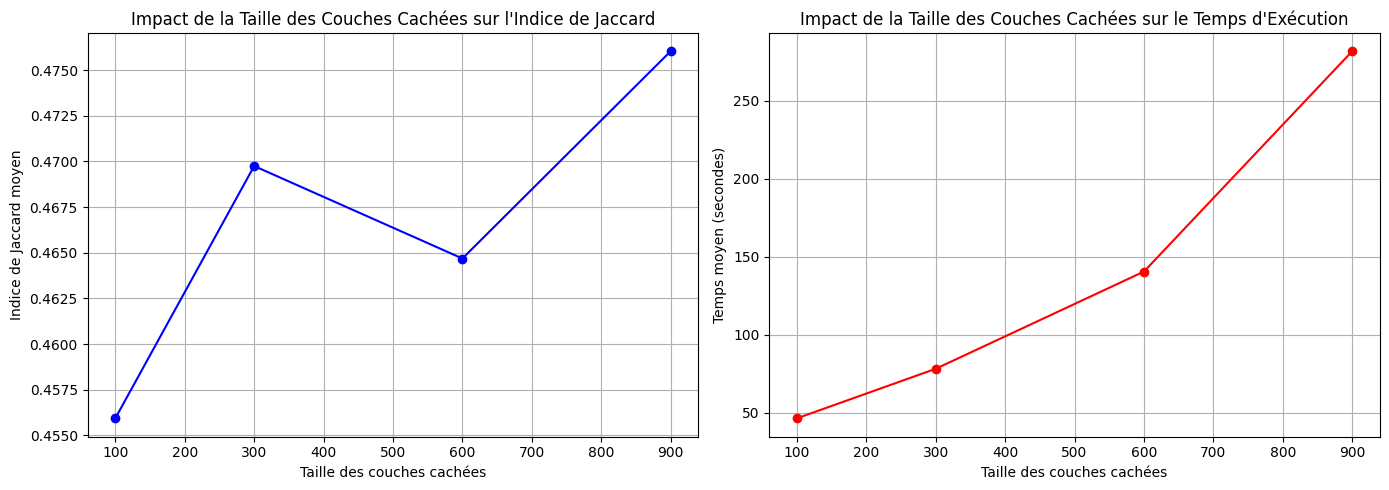

In [35]:
# Création de graphiques pour la performance et la vitesse
sizes = list(neuron_results.keys())
jaccard_scores = list(neuron_results.values())
times = list(time_results.values())

print(times)

plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(sizes, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Taille des couches cachées')
plt.ylabel('Indice de Jaccard moyen')
plt.title('Impact de la Taille des Couches Cachées sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(sizes, times, marker='o', linestyle='-', color='r')
plt.xlabel('Taille des couches cachées')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact de la Taille des Couches Cachées sur le Temps d\'Exécution')
plt.grid(True)

plt.tight_layout()
plt.show()

### Méta-paramètre : Taux d'apprentissage

In [10]:
import time
def optimize_learning_rate(learning_rates, dataset_path, target_labels, epochs=1):
    results = {}
    time_results = {}

    for lr in learning_rates:
        print(f"Testing learning rate: {lr}")
        # Initialiser le modèle avec le taux d'apprentissage actuel
        model = NN(learning_rate=lr,hidden_sizes=300)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())

        # Boucle sur le dataset
        for epoch in range(epochs):
            start_time = time.time()
            for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
                # Répartition des attributs sur un array numpy
                new_x = np.zeros(1006)
                for key, value in x.items():
                    x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                    k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                    new_x[k] = value
                # Prédiction
                y_pred = model.predict_one(new_x)
                n = 0
                # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
                dict_y_pred = dict()
                for j in y_pred :
                    if j == None : j = False
                    elif j >= 0.5 : j = True
                    else : j = False
                    dict_y_pred['y{}'.format(n)] = j
                    n+=1
                # Assurance que le dictionnaire y ne contienne que des trues et false
                for k, v in y.items():
                    y[k] = v == "1" #Convertit chaque label en booléen
                # Répartition des labels de y sur un array numpy
                new_y = np.zeros(20)
                for key, value in y.items():
                    k = int(re.findall(r'\d+',key)[0])
                    new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                    
                # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
                metric.update(y, dict_y_pred)
                metric_over_time.append(metric.get())
                # Apprentissage sur les array numpy de x et y
                model.learn_one(new_x, new_y)

            end_time = time.time()  # Fin de mesure du temps pour l'epoch
            epoch_duration = end_time - start_time
            print(f"Epoch {epoch+1}, Time: {epoch_duration}")
            metric_over_time.append(metric.get())
            print(f"Epoch {epoch+1}, Jaccard accuracy: {metric.get()}")

        results[lr] = metric.get()
        time_results[lr] = epoch_duration
        print(f"Learning Rates {lr}, Jaccard Index: {results[lr]}, Time : {time_results[lr]}")

    return results,time_results

# Liste des taux d'apprentissage à tester
learning_rates = [0.001, 0.005, 0.01, 0.02, 0.05]

# Chemin vers le dataset et cibles
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]

# Exécution de l'optimisation
lr_results,lr_time_results= optimize_learning_rate(learning_rates, dataset_path, target_labels)

Testing learning rate: 0.001


KeyboardInterrupt: 

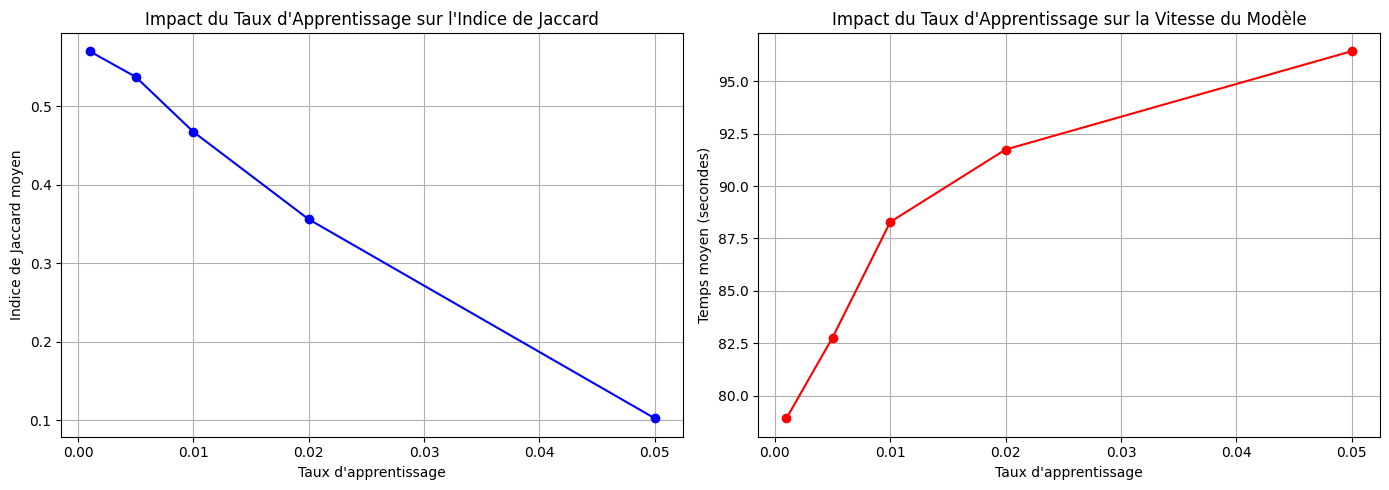

In [9]:
# Création de graphiques pour la performance et la vitesse
lr = list(lr_results.keys())
jaccard_scores = list(lr_results.values())
times = list(lr_time_results.values())


plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(learning_rates, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Taux d\'apprentissage')
plt.ylabel('Indice de Jaccard moyen')
plt.title('Impact du Taux d\'Apprentissage sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(learning_rates, times, marker='o', linestyle='-', color='r')
plt.xlabel('Taux d\'apprentissage')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact du Taux d\'Apprentissage sur la Vitesse du Modèle')
plt.grid(True)

plt.tight_layout()
plt.show()

## Méthode Replay

In [3]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, data):
        self.buffer.append(data)
    
    def sample(self, batch_size): # Cette méthode extrait un échantillon aléatoire de données du buffer.
        return random.sample(self.buffer, min(len(self.buffer), batch_size))


In [4]:
import numpy as np
import torch

class NNWithReplay(nn.Module):
    def __init__(self, learning_rate=0.01, feature_size=1006, hidden_sizes=200, label_size=20, buffer_capacity=1000, replay_batch_size=20, replay_frequency=100):
        super().__init__()
        self.model = Architecture(feature_size, hidden_sizes, label_size)
        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.replay_batch_size = replay_batch_size
        self.replay_frequency = replay_frequency
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.iteration_count = 0

    def learn_one(self, x, y):
        feature_tensor = torch.from_numpy(x).float().to(self.device)
        label_tensor = torch.from_numpy(y).float().to(self.device)

        # Ajouter au buffer de replay
        self.replay_buffer.push((feature_tensor, label_tensor))

        # Apprentissage avec les données en temps réel
        self._train_step(feature_tensor, label_tensor)

        # Apprentissage avec les données de replay
        if self.iteration_count % self.replay_frequency == 0 and len(self.replay_buffer.buffer) >= self.replay_batch_size: #Si le buffer a accumulé assez de donnée + fréquence alors apprentissage
            replay_samples = self.replay_buffer.sample(self.replay_batch_size)
            for sample_x, sample_y in replay_samples:
                self._train_step(sample_x, sample_y)
        
        # Incrémenter le compteur d'itérations
        self.iteration_count += 1

    def _train_step(self, feature_tensor, label_tensor):
        self.optimizer.zero_grad()
        pred_tensor = self.model(feature_tensor)
        loss = self.loss(pred_tensor, label_tensor)
        loss.backward()
        self.optimizer.step()

    def predict_one(self, features):
        feature_tensor = torch.from_numpy(features).float().to(self.device)
        with torch.no_grad():
            pred_tensor = self.model(feature_tensor)
        return pred_tensor.cpu().numpy()

In [7]:
# Choix du jeu de données, définition des targets dans le modèle, choix de la métrique, définition du modèle
dataset = "data/datasets/20NG.arff"
target = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]
metric = metrics.multioutput.SampleAverage(metrics.Jaccard()) #Métrique pour la perf du modèle
metric_over_time = []
i = 0
model = NNWithReplay(learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20,buffer_capacity=500,replay_batch_size=20,replay_frequency=100)

#Début de l'évaluation sur le flux
for x, y in stream.iter_arff(dataset, target, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
    # Répartition des attributs sur un array numpy
    new_x = np.zeros(1006)
    for key, value in x.items():
        x[key] = float(value) #Convertie la valeur de l'attribut en flottant
        k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
        new_x[k] = value
    # Prédiction
    y_pred = model.predict_one(new_x)
    n = 0
    # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
    dict_y_pred = dict()
    for j in y_pred :
        if j == None : j = False
        elif j >= 0.5 : j = True
        else : j = False
        dict_y_pred['y{}'.format(n)] = j
        n+=1
    # Assurance que le dictionnaire y ne contienne que des trues et false
    for k, v in y.items():
        y[k] = v == "1" #Convertit chaque label en booléen
    # Répartition des labels de y sur un array numpy
    new_y = np.zeros(20)
    for key, value in y.items():
        k = int(re.findall(r'\d+',key)[0])
        new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
    # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
    metric.update(y, dict_y_pred)
    print("{} | ".format(i) + "Jaccard accuracy : {}".format(metric.get()))
    metric_over_time.append(metric.get())
    i+=1
    # Apprentissage sur les array numpy de x et y
    model.learn_one(new_x, new_y)
# Fin du tracker de code carbone
# tracker.stop()

# Enregistrement des résultats sur un fichier json
with open("output/results.json", "w") as outfile:
    json.dump(metric_over_time, outfile)

0 | Jaccard accuracy : 0.07142857142857142
1 | Jaccard accuracy : 0.03571428571428571
2 | Jaccard accuracy : 0.05714285714285714
3 | Jaccard accuracy : 0.04285714285714286
4 | Jaccard accuracy : 0.03428571428571429
5 | Jaccard accuracy : 0.028571428571428574
6 | Jaccard accuracy : 0.04829931972789116
7 | Jaccard accuracy : 0.042261904761904764
8 | Jaccard accuracy : 0.0746031746031746
9 | Jaccard accuracy : 0.06714285714285714
10 | Jaccard accuracy : 0.06103896103896104
11 | Jaccard accuracy : 0.055952380952380955
12 | Jaccard accuracy : 0.05164835164835165
13 | Jaccard accuracy : 0.047959183673469394
14 | Jaccard accuracy : 0.04476190476190477
15 | Jaccard accuracy : 0.04196428571428572
16 | Jaccard accuracy : 0.039495798319327736
17 | Jaccard accuracy : 0.03730158730158731
18 | Jaccard accuracy : 0.03533834586466166
19 | Jaccard accuracy : 0.03357142857142858
20 | Jaccard accuracy : 0.031972789115646265
21 | Jaccard accuracy : 0.030519480519480526
22 | Jaccard accuracy : 0.0291925465

KeyboardInterrupt: 

In [13]:
def replay_iteration(dataset_path, target_labels, epochs=1, learning_rate=0.001, hidden_sizes=300,feature_size=1006,buffer_size=500, label_size=20,replay_batch_size=20,replay_frequency=10):
    results = []

    for epoch in range(epochs):
        # Initialiser le modèle avec la taille du buffer spécifiée
        model = NNWithReplay(learning_rate=learning_rate, feature_size=feature_size, hidden_sizes=hidden_sizes,
                             label_size=label_size, buffer_capacity=buffer_size, replay_batch_size=replay_batch_size, replay_frequency=replay_frequency)
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        metric_over_time = []
        
    
        for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
            # Répartition des attributs sur un array numpy
            new_x = np.zeros(1006)
            for key, value in x.items():
                x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                new_x[k] = value
            # Prédiction
            y_pred = model.predict_one(new_x)
            n = 0
            # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
            dict_y_pred = dict()
            for j in y_pred :
                if j == None : j = False
                elif j >= 0.5 : j = True
                else : j = False
                dict_y_pred['y{}'.format(n)] = j
                n+=1
            # Assurance que le dictionnaire y ne contienne que des trues et false
            for k, v in y.items():
                y[k] = v == "1" #Convertit chaque label en booléen
            # Répartition des labels de y sur un array numpy
            new_y = np.zeros(20)
            for key, value in y.items():
                k = int(re.findall(r'\d+',key)[0])
                new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                
            # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
            metric.update(y, dict_y_pred)
            metric_over_time.append(metric.get())
            # Apprentissage sur les array numpy de x et y
            model.learn_one(new_x, new_y)

        results.append(metric.get())
        print(f"Epoch: {epoch}, Jaccard Index: {metric.get()}")

    return results

# Chemin vers le dataset et cibles
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]

# Exécution de l'optimisation
buffer_capacity_results = replay_iteration(dataset_path, target_labels,5)


Epoch: 0, Jaccard Index: 0.6099329509005704
Epoch: 1, Jaccard Index: 0.6109270293609638
Epoch: 2, Jaccard Index: 0.6096928201332324
Epoch: 3, Jaccard Index: 0.609611645694545
Epoch: 4, Jaccard Index: 0.6074721418477886


In [14]:
moy = np.mean(buffer_capacity_results)
print(moy)
std = np.std(buffer_capacity_results)
print(std)

0.6095273175874201
0.0011297770644534638


## Optmisation méta-paramètre de la Méthode Replay

### Méta-paramètre : Buffer_size

In [8]:
def optimize_buffer_capacity(buffer_sizes, dataset_path, target_labels, epochs=1, learning_rate=0.01, hidden_sizes=300,feature_size=1006, label_size=20,replay_batch_size=20,replay_frequency=1000):
    results = {}
    time_results = {}

    for buffer_size in buffer_sizes:
        print(f"Testing buffer capacity: {buffer_size}")
        # Initialiser le modèle avec la taille du buffer spécifiée
        model = NNWithReplay(learning_rate=learning_rate, feature_size=feature_size, hidden_sizes=hidden_sizes,
                             label_size=label_size, buffer_capacity=buffer_size, replay_batch_size=replay_batch_size, replay_frequency=replay_frequency)
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        metric_over_time = []
        
        # Boucle sur le dataset
        for epoch in range(epochs):
            start_time = time.time()
            for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
                # Répartition des attributs sur un array numpy
                new_x = np.zeros(1006)
                for key, value in x.items():
                    x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                    k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                    new_x[k] = value
                # Prédiction
                y_pred = model.predict_one(new_x)
                n = 0
                # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
                dict_y_pred = dict()
                for j in y_pred :
                    if j == None : j = False
                    elif j >= 0.5 : j = True
                    else : j = False
                    dict_y_pred['y{}'.format(n)] = j
                    n+=1
                # Assurance que le dictionnaire y ne contienne que des trues et false
                for k, v in y.items():
                    y[k] = v == "1" #Convertit chaque label en booléen
                # Répartition des labels de y sur un array numpy
                new_y = np.zeros(20)
                for key, value in y.items():
                    k = int(re.findall(r'\d+',key)[0])
                    new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                    
                # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
                metric.update(y, dict_y_pred)
                metric_over_time.append(metric.get())
                # Apprentissage sur les array numpy de x et y
                model.learn_one(new_x, new_y)

            end_time = time.time()  # Fin de mesure du temps pour l'epoch
            epoch_duration = end_time - start_time
            metric_over_time.append(metric.get())

        results[buffer_size] = metric.get()
        time_results[buffer_size] = epoch_duration
        print(f"Buffer Size {buffer_size}, Jaccard Index: {results[buffer_size]}, Time : {time_results[buffer_size]}")

    return results,time_results


# Liste des tailles de mémoire à tester
buffer_sizes = [100, 1000, 2500, 5000]

# Chemin vers le dataset et cibles
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]

# Exécution de l'optimisation
buffer_capacity_results,buffer_time_results = optimize_buffer_capacity(buffer_sizes, dataset_path, target_labels)


Testing buffer capacity: 100


NameError: name 'time' is not defined

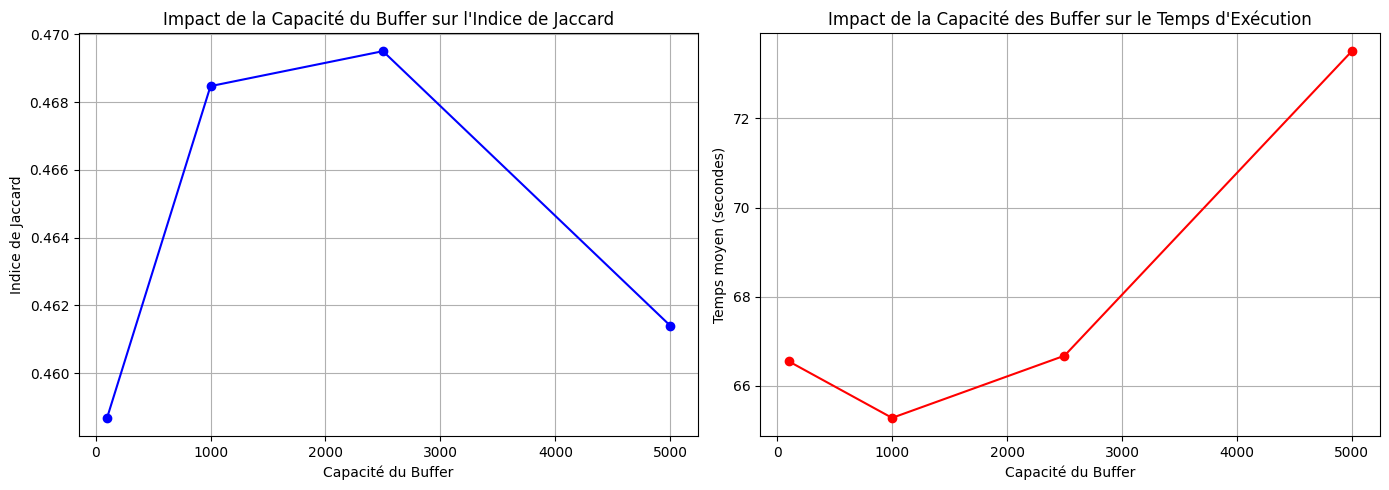

In [22]:
# Création de graphiques pour la performance et la vitesse
buffer_sizes = list(buffer_capacity_results.keys())
jaccard_scores = list(buffer_capacity_results.values())
times = list(buffer_time_results.values())

plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(buffer_sizes, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Capacité du Buffer')
plt.ylabel('Indice de Jaccard')
plt.title('Impact de la Capacité du Buffer sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(buffer_sizes, times, marker='o', linestyle='-', color='r')
plt.xlabel('Capacité du Buffer')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact de la Capacité des Buffer sur le Temps d\'Exécution')
plt.grid(True)

plt.tight_layout()
plt.show()

### Méta-paramètre : Replay_frequency

In [5]:
import time

def optimize_replay_frequency(frequencies, dataset_path, target_labels, epochs=1, learning_rate=0.01, hidden_sizes=300, label_size=20, buffer_capacity=1000,replay_batch_size=20):
    results = {}
    time_results = {}

    for frequency in frequencies:
        print(f"Testing replay frequency: {frequency}")
        # Initialiser le modèle avec la fréquence de replay spécifiée
        model = NNWithReplay(learning_rate=learning_rate, feature_size=1006, hidden_sizes=hidden_sizes,
                             label_size=label_size, buffer_capacity=buffer_capacity, replay_batch_size=replay_batch_size, replay_frequency=frequency)
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        metric_over_time = []

        # Boucle d'entraînement sur le dataset
        # Boucle sur le dataset
        for epoch in range(epochs):
            start_time = time.time()
            for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
                # Répartition des attributs sur un array numpy
                new_x = np.zeros(1006)
                for key, value in x.items():
                    x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                    k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                    new_x[k] = value
                # Prédiction
                y_pred = model.predict_one(new_x)
                n = 0
                # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
                dict_y_pred = dict()
                for j in y_pred :
                    if j == None : j = False
                    elif j >= 0.5 : j = True
                    else : j = False
                    dict_y_pred['y{}'.format(n)] = j
                    n+=1
                # Assurance que le dictionnaire y ne contienne que des trues et false
                for k, v in y.items():
                    y[k] = v == "1" #Convertit chaque label en booléen
                # Répartition des labels de y sur un array numpy
                new_y = np.zeros(20)
                for key, value in y.items():
                    k = int(re.findall(r'\d+',key)[0])
                    new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                    
                # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
                metric.update(y, dict_y_pred)
                metric_over_time.append(metric.get())
                # Apprentissage sur les array numpy de x et y
                model.learn_one(new_x, new_y)

            end_time = time.time()  # Fin de mesure du temps pour l'epoch
            epoch_duration = end_time - start_time
            metric_over_time.append(metric.get())

        results[frequency] = metric.get()
        time_results[frequency] = epoch_duration
        print(f"Replay frequency {frequency}, Jaccard Index: {results[frequency]}, Time : {time_results[frequency]}")

    return results,time_results

# Liste des fréquences de replay à tester
frequencies = [10,100,500,1000]

# Chemin vers le dataset et cibles
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]

# Exécution de l'optimisation
frequency_results,frequency_time_results = optimize_replay_frequency(frequencies, dataset_path, target_labels)


Testing replay frequency: 10
Replay frequency 10, Jaccard Index: 0.47257883049593025, Time : 171.8750422000885
Testing replay frequency: 100
Replay frequency 100, Jaccard Index: 0.46625259067357516, Time : 71.99580073356628
Testing replay frequency: 500
Replay frequency 500, Jaccard Index: 0.4633799654576877, Time : 64.58899641036987
Testing replay frequency: 1000
Replay frequency 1000, Jaccard Index: 0.4651116456945475, Time : 69.830561876297


{10: 171.8750422000885, 100: 71.99580073356628, 500: 64.58899641036987, 1000: 69.830561876297}


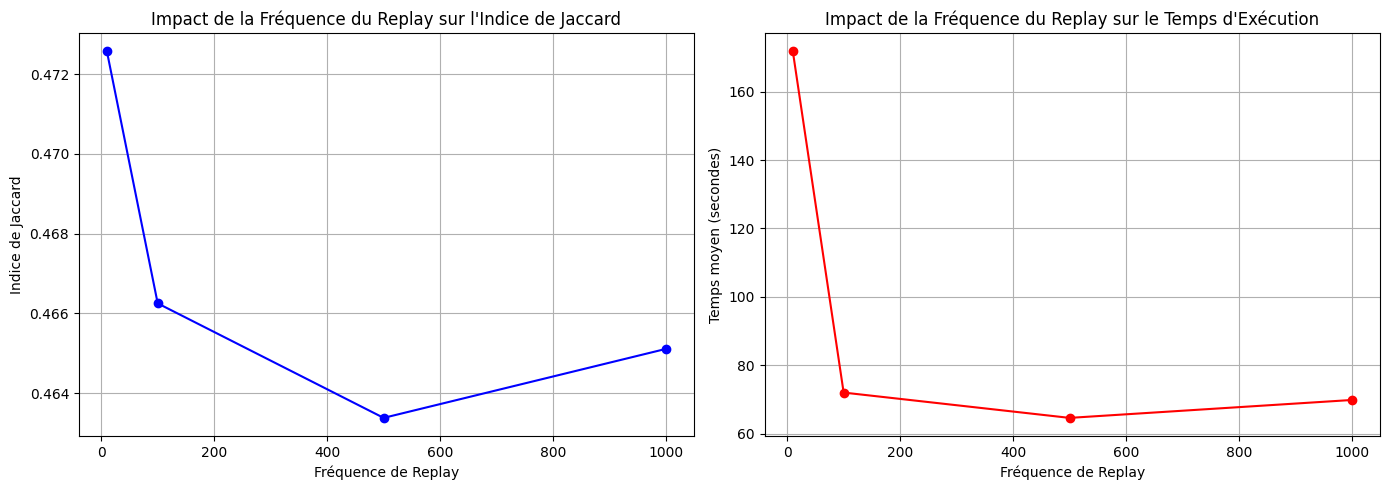

In [6]:
import matplotlib.pyplot as plt

# Préparation des données pour le graphique
frequencies = list(frequency_results.keys())
jaccard_scores = list(frequency_results.values())
times = list(frequency_time_results.values())

print(frequency_time_results)
plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(frequencies, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fréquence de Replay')
plt.ylabel('Indice de Jaccard')
plt.title('Impact de la Fréquence du Replay sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(frequencies, times, marker='o', linestyle='-', color='r')
plt.xlabel('Fréquence de Replay')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact de la Fréquence du Replay sur le Temps d\'Exécution')
plt.grid(True)

plt.tight_layout()
plt.show()

### Méta_paramètre : replay_batch_size

In [11]:
import time

def optimize_replay_batch_size(batch_sizes, dataset_path, target_labels, epochs=1,learning_rate=0.01, hidden_sizes=300,feature_size=1006, label_size=20,buffer_sizes=1000,replay_frequency=1000):
    results = {}
    time_results = {}
    for batch_size in batch_sizes:
        print(f"Testing replay batch size: {batch_size}")
        # Initialiser le modèle avec la taille de batch de replay actuelle
        model = NNWithReplay(learning_rate=learning_rate, feature_size=feature_size, hidden_sizes=hidden_sizes, label_size=label_size,
                             buffer_capacity=buffer_sizes, replay_batch_size=batch_size, replay_frequency=replay_frequency)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        
        # Boucle sur le dataset
        for epoch in range(epochs):
            start_time = time.time()
            for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
                # Répartition des attributs sur un array numpy
                new_x = np.zeros(1006)
                for key, value in x.items():
                    x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                    k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                    new_x[k] = value
                # Prédiction
                y_pred = model.predict_one(new_x)
                n = 0
                # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
                dict_y_pred = dict()
                for j in y_pred :
                    if j == None : j = False
                    elif j >= 0.5 : j = True
                    else : j = False
                    dict_y_pred['y{}'.format(n)] = j
                    n+=1
                # Assurance que le dictionnaire y ne contienne que des trues et false
                for k, v in y.items():
                    y[k] = v == "1" #Convertit chaque label en booléen
                # Répartition des labels de y sur un array numpy
                new_y = np.zeros(20)
                for key, value in y.items():
                    k = int(re.findall(r'\d+',key)[0])
                    new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
                    
                # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
                metric.update(y, dict_y_pred)
                metric_over_time.append(metric.get())
                # Apprentissage sur les array numpy de x et y
                model.learn_one(new_x, new_y)

            end_time = time.time()  # Fin de mesure du temps pour l'epoch
            epoch_duration = end_time - start_time
            metric_over_time.append(metric.get())

        results[batch_size] = metric.get()
        time_results[batch_size] = epoch_duration
        print(f"Batch Size {batch_size}, Jaccard Index: {results[batch_size]}, Time : {time_results[batch_size]}")

    return results,time_results

batch_sizes = [10,100,500,1000]
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]
batch_size_results,batch_time_results = optimize_replay_batch_size(batch_sizes, dataset_path, target_labels)

Testing replay batch size: 10
Batch Size 10, Jaccard Index: 0.4664058721934361, Time : 62.25214457511902
Testing replay batch size: 100
Batch Size 100, Jaccard Index: 0.463779460608476, Time : 69.08401584625244
Testing replay batch size: 500
Batch Size 500, Jaccard Index: 0.46870404638539354, Time : 95.53475761413574
Testing replay batch size: 1000
Batch Size 1000, Jaccard Index: 0.4797677029360954, Time : 97.77057409286499


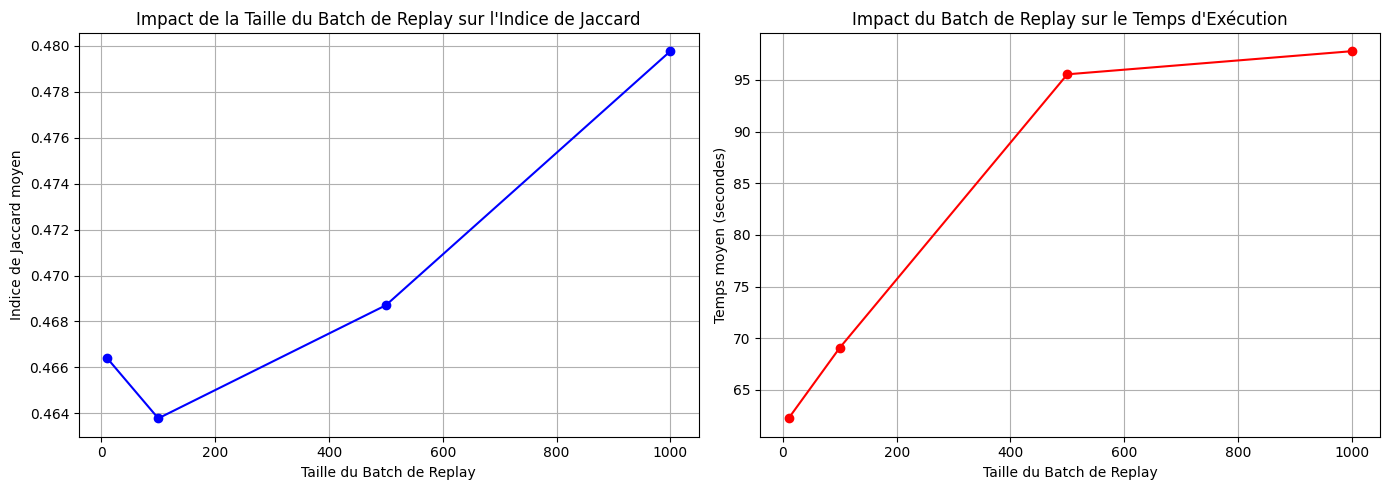

In [12]:
import matplotlib.pyplot as plt

# Extraction des données pour le graphique
sizes = list(batch_size_results.keys())
jaccard_scores = list(batch_size_results.values())
times = list(batch_time_results.values())

plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Taille du Batch de Replay')
plt.ylabel('Indice de Jaccard moyen')
plt.title('Impact de la Taille du Batch de Replay sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(batch_sizes, times, marker='o', linestyle='-', color='r')
plt.xlabel('Taille du Batch de Replay')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact du Batch de Replay sur le Temps d\'Exécution')
plt.grid(True)

plt.tight_layout()
plt.show()

## RNN avec LSTM

In [15]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)# Initialisation du LSTM
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass: x doit être de la forme (batch, sequence_length, features)
        lstm_out, _ = self.lstm(x) # Traitement de la séquence par le LSTM.
        # Extraction de la sortie du dernier pas de temps de chaque séquence pour la classification.
        last_time_step = lstm_out[:, -1, :]
        output = self.linear(last_time_step) #Application de la couche linéaire
        return self.sigmoid(output)

In [16]:
# Définition du modèle
class LSTMForContinualLearning:
    def __init__(self, learning_rate=0.01, feature_size=1006, hidden_sizes=200, label_size=20,sequence_length=5):
        self.model = LSTMModel(feature_size, hidden_sizes, label_size) #Initialisation du modèle LSTM 
        self.loss_fn = nn.BCELoss()
        self.buffer = deque([], maxlen=sequence_length)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sequence_length = sequence_length
        self.model.to(self.device)

    def train(self, features, labels):
        self.buffer.append(features)
        if len(self.buffer) < self.sequence_length:
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
        else:
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
            self.buffer.popleft()  # Supprimez le premier élément pour permettre le chevauchement
        labels = torch.tensor([labels], dtype=torch.float32).to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(features)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()

    def predict_one(self, features):
        # Préparation des données pour la prédiction
        self.buffer.append(features)
        if len(self.buffer) < self.sequence_length:
            # Si le buffer n'est pas encore plein, utilisez simplement les données disponibles
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
        else:
            # Si le buffer est plein, faites la prédiction et gérez le chevauchement
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
            self.buffer.popleft()  # Supprimez le premier élément pour permettre le chevauchement
        with torch.no_grad():
            pred_tensor = self.model(features)
        return pred_tensor.cpu().numpy()[0] #Retourne la prédiction après suppression de la dimension de batch

In [98]:
# Choix du jeu de données, définition des targets dans le modèle, choix de la métrique, définition du modèle
dataset = "data/datasets/20NG.arff"
target = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]
metric = metrics.multioutput.SampleAverage(metrics.Jaccard()) #Métrique pour la perf du modèle
metric_over_time = []
i = 0
model = LSTMForContinualLearning(learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20,sequence_length=1)

#Début de l'évaluation sur le flux
for x, y in stream.iter_arff(dataset, target, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
    # Répartition des attributs sur un array numpy
    new_x = np.zeros(1006)
    for key, value in x.items():
        x[key] = float(value) #Convertie la valeur de l'attribut en flottant
        k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
        new_x[k] = value
    # Prédiction
    y_pred = model.predict_one(new_x)
    n = 0
    # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
    dict_y_pred = dict()
    for j in y_pred :
        if j == None : j = False
        elif j >= 0.5 : j = True
        else : j = False
        dict_y_pred['y{}'.format(n)] = j
        n+=1
    # Assurance que le dictionnaire y ne contienne que des trues et false
    for k, v in y.items():
        y[k] = v == "1" #Convertit chaque label en booléen
    # Répartition des labels de y sur un array numpy
    new_y = np.zeros(20)
    for key, value in y.items():
        k = int(re.findall(r'\d+',key)[0])
        new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
    # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
    metric.update(y, dict_y_pred)
    print("{} | ".format(i) + "Jaccard accuracy : {}".format(metric.get()))
    metric_over_time.append(metric.get())
    i+=1
    # Apprentissage sur les array numpy de x et y
    model.train(new_x, new_y)
# Fin du tracker de code carbone
# tracker.stop()

# Enregistrement des résultats sur un fichier json
with open("output/results.json", "w") as outfile:
    json.dump(metric_over_time, outfile)

0 | Jaccard accuracy : 0.0
1 | Jaccard accuracy : 0.0
2 | Jaccard accuracy : 0.0
3 | Jaccard accuracy : 0.0
4 | Jaccard accuracy : 0.0
5 | Jaccard accuracy : 0.0
6 | Jaccard accuracy : 0.0
7 | Jaccard accuracy : 0.0
8 | Jaccard accuracy : 0.0
9 | Jaccard accuracy : 0.0
10 | Jaccard accuracy : 0.0
11 | Jaccard accuracy : 0.0
12 | Jaccard accuracy : 0.0
13 | Jaccard accuracy : 0.03571428571428571
14 | Jaccard accuracy : 0.03333333333333333
15 | Jaccard accuracy : 0.03125
16 | Jaccard accuracy : 0.029411764705882353
17 | Jaccard accuracy : 0.027777777777777776
18 | Jaccard accuracy : 0.02631578947368421
19 | Jaccard accuracy : 0.024999999999999998
20 | Jaccard accuracy : 0.023809523809523808
21 | Jaccard accuracy : 0.022727272727272724
22 | Jaccard accuracy : 0.021739130434782605
23 | Jaccard accuracy : 0.02083333333333333
24 | Jaccard accuracy : 0.019999999999999997
25 | Jaccard accuracy : 0.01923076923076923
26 | Jaccard accuracy : 0.018518518518518517
27 | Jaccard accuracy : 0.01785714

In [26]:
def LSTM_iteration(dataset_path, target_labels,epochs):
    results = []
    for epoch in range(epochs):
        model = LSTMForContinualLearning(learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20, sequence_length=1)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        #Début de l'évaluation sur le flux
        for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
            # Répartition des attributs sur un array numpy
            new_x = np.zeros(1006)
            for key, value in x.items():
                x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                new_x[k] = value
            # Prédiction
            y_pred = model.predict_one(new_x)
            n = 0
            # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
            dict_y_pred = dict()
            for j in y_pred :
                if j == None : j = False
                elif j >= 0.5 : j = True
                else : j = False
                dict_y_pred['y{}'.format(n)] = j
                n+=1
            # Assurance que le dictionnaire y ne contienne que des trues et false
            for k, v in y.items():
                y[k] = v == "1" #Convertit chaque label en booléen
            # Répartition des labels de y sur un array numpy
            new_y = np.zeros(20)
            for key, value in y.items():
                k = int(re.findall(r'\d+',key)[0])
                new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
            # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
            metric.update(y, dict_y_pred)
            metric_over_time.append(metric.get())
            # Apprentissage sur les array numpy de x et y
            model.train(new_x, new_y)

        results.append(metric.get())
        print(f"Epoch : {epoch}, Jaccard Index: {metric.get()}")

    return results

# Appel de la fonction
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]
sequence_results =LSTM_iteration(dataset_path, target_labels,5)


Epoch : 0, Jaccard Index: 0.5688955094991378
Epoch : 1, Jaccard Index: 0.5692893354486613
Epoch : 2, Jaccard Index: 0.5707819727767897
Epoch : 3, Jaccard Index: 0.567819477154967
Epoch : 4, Jaccard Index: 0.5675187104202634


In [27]:
moy = np.mean(sequence_results)
print(moy)
std = np.std(sequence_results)
print(std)

0.5688610010599638
0.0011628679825214311


## Méta-paramètre : Séquence Length

In [19]:
import time

def optimize_sequence_length(sequence_lengths, dataset_path, target_labels):
    results = {}
    time_results = {}
    for length in sequence_lengths:
        print(f"Testing sequence length: {length}")
        model = LSTMForContinualLearning(learning_rate=0.01, feature_size=1006, hidden_sizes=300, label_size=20, sequence_length=length)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        start_time = time.time()
        #Début de l'évaluation sur le flux
        for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
            # Répartition des attributs sur un array numpy
            new_x = np.zeros(1006)
            for key, value in x.items():
                x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                new_x[k] = value
            # Prédiction
            y_pred = model.predict_one(new_x)
            n = 0
            # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
            dict_y_pred = dict()
            for j in y_pred :
                if j == None : j = False
                elif j >= 0.5 : j = True
                else : j = False
                dict_y_pred['y{}'.format(n)] = j
                n+=1
            # Assurance que le dictionnaire y ne contienne que des trues et false
            for k, v in y.items():
                y[k] = v == "1" #Convertit chaque label en booléen
            # Répartition des labels de y sur un array numpy
            new_y = np.zeros(20)
            for key, value in y.items():
                k = int(re.findall(r'\d+',key)[0])
                new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
            # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
            metric.update(y, dict_y_pred)
            metric_over_time.append(metric.get())
            # Apprentissage sur les array numpy de x et y
            model.train(new_x, new_y)
            
        end_time = time.time()  # Fin de mesure du temps pour l'epoch
        epoch_duration = end_time - start_time
        metric_over_time.append(metric.get())

        results[length] = metric.get()
        time_results[length] = epoch_duration
        print(f"Sequence Length {length}, Jaccard Index: {results[length]}, Time : {time_results[length]}")

    return results,time_results

# Appel de la fonction
sequence_lengths = [1,5,10,20]  # Différentes longueurs de séquences à tester
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]
sequence_results,sequence_time_results =optimize_sequence_length(sequence_lengths, dataset_path, target_labels)


Testing sequence length: 1
Sequence Length 1, Jaccard Index: 0.5560880829015554, Time : 423.12308955192566
Testing sequence length: 5
Sequence Length 5, Jaccard Index: 0.4117685664939547, Time : 347.94415068626404
Testing sequence length: 10
Sequence Length 10, Jaccard Index: 0.4144214162348874, Time : 463.93386459350586
Testing sequence length: 20
Sequence Length 20, Jaccard Index: 0.417232790525539, Time : 444.0187005996704


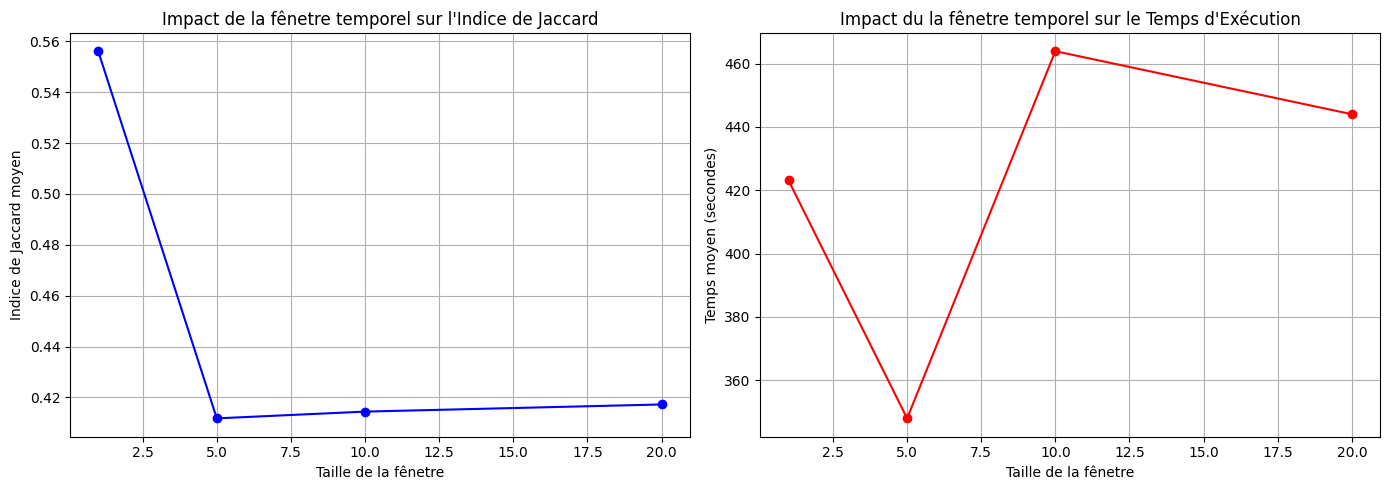

In [20]:
import matplotlib.pyplot as plt

# Extraction des données pour le graphique
sequence_lengths = list(sequence_results.keys())
jaccard_scores = list(sequence_results.values())
times = list(sequence_time_results.values())

plt.figure(figsize=(14, 5))

# Graphique pour l'indice de Jaccard
plt.subplot(1, 2, 1)
plt.plot(sequence_lengths, jaccard_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Taille de la fênetre')
plt.ylabel('Indice de Jaccard moyen')
plt.title('Impact de la fênetre temporel sur l\'Indice de Jaccard')
plt.grid(True)

# Graphique pour le temps d'exécution
plt.subplot(1, 2, 2)
plt.plot(sequence_lengths, times, marker='o', linestyle='-', color='r')
plt.xlabel('Taille de la fênetre')
plt.ylabel('Temps moyen (secondes)')
plt.title('Impact du la fênetre temporel sur le Temps d\'Exécution')
plt.grid(True)
plt.tight_layout()
plt.show()

## Mémoire intégrée + Méthode Replay

In [28]:
class ArchitectureWithMemory(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers, batch_first=True)# Initialisation du LSTM
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass: x doit être de la forme (batch, sequence_length, features)
        lstm_out, _ = self.lstm(x) # Traitement de la séquence par le LSTM.
        # Extraction de la sortie du dernier pas de temps de chaque séquence pour la classification.
        last_time_step = lstm_out[:, -1, :]
        output = self.linear(last_time_step) #Application de la couche linéaire
        return self.sigmoid(output)

In [29]:
class NNWithMemory(nn.Module):
    def __init__(self, learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20, buffer_capacity=500, replay_batch_size=20, replay_frequency=10,sequence_length=1):
        super().__init__()
        # Initialisation du modèle avec mémoire, configuration du LSTM et des couches de sortie
        self.model = ArchitectureWithMemory(feature_size, hidden_sizes, label_size)
        self.loss = nn.BCELoss()
        self.buffer = deque([], maxlen=sequence_length)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        # Buffer de replay pour stocker et réutiliser les anciennes données
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.replay_batch_size = replay_batch_size
        self.replay_frequency = replay_frequency
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.sequence_length = sequence_length
        self.iteration_count =0

    def learn_one(self, features, labels):
        # Préparation des tensors pour les données et les labels
        self.buffer.append(features)
        if len(self.buffer) < self.sequence_length:
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
        else:
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
            self.buffer.popleft()  # Supprimez le premier élément pour permettre le chevauchement
        labels = torch.tensor([labels], dtype=torch.float32).to(self.device)
        # Ajout des données au buffer de replay
        self.replay_buffer.push((features, labels))

        # Apprentissage en temps réel avec les données courantes
        self._train_step(features, labels)

        # Apprentissage par replay lorsque le buffer atteint une certaine taille
        if  self.iteration_count% self.replay_frequency == 0 and len(self.replay_buffer.buffer) >= self.replay_batch_size:
            replay_samples = self.replay_buffer.sample(self.replay_batch_size)
            for sample_x, sample_y in replay_samples:
                self._train_step(sample_x, sample_y)

        # Incrémenter le compteur d'itérations
        self.iteration_count += 1

    def _train_step(self, feature_tensor, label_tensor):
        self.optimizer.zero_grad()
        pred_tensor = self.model(feature_tensor)
        loss = self.loss(pred_tensor, label_tensor)
        loss.backward()
        self.optimizer.step()

    def predict_one(self, features):
        # Préparation des données pour la prédiction
        self.buffer.append(features)
        if len(self.buffer) < self.sequence_length:
            # Si le buffer n'est pas encore plein, utilisez simplement les données disponibles
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
        else:
            # Si le buffer est plein, faites la prédiction et gérez le chevauchement
            features = torch.tensor([list(self.buffer)], dtype=torch.float32).to(self.device)
            self.buffer.popleft()  # Supprimez le premier élément pour permettre le chevauchement
        with torch.no_grad():
            pred_tensor = self.model(features)
        return pred_tensor.cpu().numpy()[0]  #Retourne la prédiction après suppression de la dimension de batch

In [112]:
# Choix du jeu de données, définition des targets dans le modèle, choix de la métrique, définition du modèle
dataset = "data/datasets/20NG.arff"
target = [
        "y0",
        "y1",
        "y2",
        "y3",
        "y4",
        "y5",
        "y6",
        "y7",
        "y8",
        "y9",
        "y10",
        "y11",
        "y12",
        "y13",
        "y14",
        "y15",
        "y16",
        "y17",
        "y18",
        "y19",
    ]
metric = metrics.multioutput.SampleAverage(metrics.Jaccard()) #Métrique pour la perf du modèle
metric_over_time = []
i = 0
model = NNWithMemory(learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20,sequence_length=1)

#Début de l'évaluation sur le flux
for x, y in stream.iter_arff(dataset, target, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
    # Répartition des attributs sur un array numpy
    new_x = np.zeros(1006)
    for key, value in x.items():
        x[key] = float(value) #Convertie la valeur de l'attribut en flottant
        k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
        new_x[k] = value
    # Prédiction
    y_pred = model.predict_one(new_x)
    n = 0
    # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
    dict_y_pred = dict()
    for j in y_pred :
        if j == None : j = False
        elif j >= 0.5 : j = True
        else : j = False
        dict_y_pred['y{}'.format(n)] = j
        n+=1
    # Assurance que le dictionnaire y ne contienne que des trues et false
    for k, v in y.items():
        y[k] = v == "1" #Convertit chaque label en booléen
    # Répartition des labels de y sur un array numpy
    new_y = np.zeros(20)
    for key, value in y.items():
        k = int(re.findall(r'\d+',key)[0])
        new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
    # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
    metric.update(y, dict_y_pred)
    print("{} | ".format(i) + "Jaccard accuracy : {}".format(metric.get()))
    metric_over_time.append(metric.get())
    i+=1
    # Apprentissage sur les array numpy de x et y
    model.learn_one(new_x, new_y)
# Fin du tracker de code carbone
# tracker.stop()

# Enregistrement des résultats sur un fichier json
with open("output/results.json", "w") as outfile:
    json.dump(metric_over_time, outfile)

0 | Jaccard accuracy : 0.125
1 | Jaccard accuracy : 0.0625
2 | Jaccard accuracy : 0.07870370370370369
3 | Jaccard accuracy : 0.09027777777777776
4 | Jaccard accuracy : 0.07222222222222222
5 | Jaccard accuracy : 0.06018518518518518
6 | Jaccard accuracy : 0.051587301587301584
7 | Jaccard accuracy : 0.04513888888888889
8 | Jaccard accuracy : 0.040123456790123455
9 | Jaccard accuracy : 0.03611111111111111
10 | Jaccard accuracy : 0.032828282828282825
11 | Jaccard accuracy : 0.030092592592592587
12 | Jaccard accuracy : 0.027777777777777773
13 | Jaccard accuracy : 0.02579365079365079
14 | Jaccard accuracy : 0.02407407407407407
15 | Jaccard accuracy : 0.02256944444444444
16 | Jaccard accuracy : 0.021241830065359475
17 | Jaccard accuracy : 0.020061728395061727
18 | Jaccard accuracy : 0.019005847953216373
19 | Jaccard accuracy : 0.018055555555555554
20 | Jaccard accuracy : 0.017195767195767195
21 | Jaccard accuracy : 0.016414141414141412
22 | Jaccard accuracy : 0.015700483091787436
23 | Jaccard 

In [ ]:
#0.6121403898346879

In [31]:
def LSTM_iteration(dataset_path, target_labels,epochs):
    results = []
    for epoch in range(epochs):
        model = NNWithMemory(learning_rate=0.001, feature_size=1006, hidden_sizes=300, label_size=20,sequence_length=1)
        metric_over_time = []
        metric = metrics.multioutput.SampleAverage(metrics.Jaccard())
        #Début de l'évaluation sur le flux
        for x, y in stream.iter_arff(dataset_path, target_labels, sparse=True): #Pr chaque data renvoi deux dico : x -> Ensemble de carac , y-> Emsemble de label
            # Répartition des attributs sur un array numpy
            new_x = np.zeros(1006)
            for key, value in x.items():
                x[key] = float(value) #Convertie la valeur de l'attribut en flottant
                k = int(re.findall(r'\d+',key)[0]) #"X49" -> "49".
                new_x[k] = value
            # Prédiction
            y_pred = model.predict_one(new_x)
            n = 0
            # Convertion de y_pred en dictionnaire contenant des true et false pour la comparaison avec y
            dict_y_pred = dict()
            for j in y_pred :
                if j == None : j = False
                elif j >= 0.5 : j = True
                else : j = False
                dict_y_pred['y{}'.format(n)] = j
                n+=1
            # Assurance que le dictionnaire y ne contienne que des trues et false
            for k, v in y.items():
                y[k] = v == "1" #Convertit chaque label en booléen
            # Répartition des labels de y sur un array numpy
            new_y = np.zeros(20)
            for key, value in y.items():
                k = int(re.findall(r'\d+',key)[0])
                new_y[k] = value # Affecte la valeur booléenne (True ou False) convertie en 1.0 ou 0.0
            # Mise à jour de la métrique avec les dictionnaires de y et de la prédiction
            metric.update(y, dict_y_pred)
            metric_over_time.append(metric.get())
            # Apprentissage sur les array numpy de x et y
            model.learn_one(new_x, new_y)

        results.append(metric.get())
        print(f"Epoch : {epoch}, Jaccard Index: {metric.get()}")

    return results

# Appel de la fonction
dataset_path = "data/datasets/20NG.arff"
target_labels = [f'y{i}' for i in range(20)]
results_ =LSTM_iteration(dataset_path, target_labels,3)

Epoch : 0, Jaccard Index: 0.6144775474956845
Epoch : 1, Jaccard Index: 0.6123571017353395
Epoch : 2, Jaccard Index: 0.6121674068591109


In [32]:
moy = np.mean(results_)
print(moy)
std = np.std(results_)
print(std)

0.6130006853633784
0.0010471667663738765
